In [588]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [589]:
np.set_printoptions(threshold=np.inf)

In [590]:
zmin = 0
zmax = 255
n = 256
l = 10
B = [np.log(13), np.log(10), np.log(4), np.log(3.2), np.log(1), np.log(0.8), np.log(0.3), np.log(1/4), np.log(1/60), np.log(1/80), np.log(1/320), np.log(1/400), np.log(1/1000)]

In [591]:
# returns an array of tuples containing 3 color channels of each image
def get_img_data():
    r_c = []
    g_c = []
    b_c = []
    
#     for entry in os.scandir('./exposures'):
    for entry in range(1, 14):
        im = cv2.imread('./exposures/img{}.jpg'.format(entry), cv2.IMREAD_COLOR)
        b, g, r = cv2.split(im)
        
        r_c.append(r)
        g_c.append(g)
        b_c.append(b)
        
    return r_c, g_c, b_c

In [592]:
r, g, b = get_img_data()
r, g, b = np.array(r), np.array(g), np.array(b)

In [593]:
r_full = r.reshape(r.shape[0], r.shape[1]*r.shape[2])
g_full = g.reshape(g.shape[0], g.shape[1]*g.shape[2])
b_full = b.reshape(b.shape[0], b.shape[1]*b.shape[2])

In [594]:
r = r_full[:, ::15729]
g = g_full[:, ::15729]
b = b_full[:, ::15729]
# r = r[:, ::7865]

In [595]:
def w(z):
    if z <= 0.5*(zmin + zmax):
        return z - zmin
    return zmax - z

In [596]:
def gsolve(z, B, l):
    z = np.transpose(z)
    A = np.zeros((z.shape[0]*z.shape[1]+255, n+z.shape[0]))
    b = np.zeros((A.shape[0], 1))
    k = 0
    
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            wij = w(z[i, j]+1)
            A[k, z[i, j]+1] = wij
            A[k, n+i] = -wij
            b[k, 0] = wij*B[j]
            k+=1
    
    A[k, 127] = 0
    k+=1
    
    for i in range(1, n-2):
        A[k, i] = l*w(i+1)
        A[k, i+1] = -2*l*w(i+1)
        A[k, i+2] = l*w(i+1)
        k+=1
        
    return A, b

In [597]:
def get_g_lE(c):
    A, b = gsolve(c, B, l)
    x = np.linalg.lstsq(A, b, rcond=None)
    g = x[0].reshape(x[0].shape[0])
    g = g[:n]
    lE = x[0][n:]
    
    return g, lE

In [598]:
r_g, r_lE = get_g_lE(r)
g_g, g_lE = get_g_lE(g)
b_g, b_lE = get_g_lE(b)

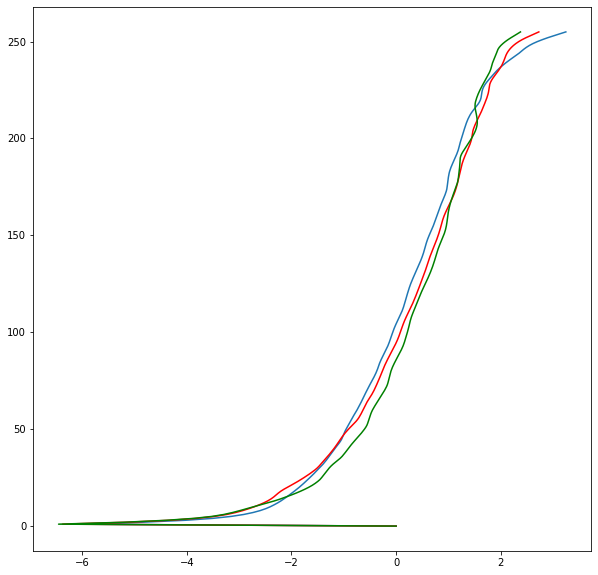

In [599]:
plt.figure(figsize=(10,10))
plt.plot(r_g, range(256), '-')
plt.plot(g_g, range(256), 'r-')
plt.plot(b_g, range(256), 'g-')

In [600]:
# A, b = gsolve(r, B, l)

In [601]:
# u, s, vh = np.linalg.svd(A)

In [602]:
# x = np.linalg.lstsq(A, b, rcond=None)

In [603]:
# g = x[0].reshape(x[0].shape[0])
# g = g[:n]

In [604]:
# x1, y1 = [g[r[0][10]], g[r[0][20]], g[r[0][30]], g[r[0][40]], g[r[0][49]]], [r[0][10], r[0][20], r[0][30], r[0][40], r[0][49]]
# x2, y2 = [g[r[6][10]], g[r[6][20]], g[r[6][30]], g[r[6][40]], g[r[6][49]]], [r[6][10], r[6][20], r[6][30], r[6][40], r[6][49]]
# x3, y3 = [g[r[12][10]], g[r[12][20]], g[r[12][30]], g[r[12][40]], g[r[12][49]]], [r[12][10], r[12][20], r[12][30], r[12][40], r[12][49]]

In [605]:
# x1, y1 = [g[r[0][30]], g[r[0][60]], g[r[0][90]]], [r[0][30], r[0][60], r[0][90]]
# x2, y2 = [g[r[6][30]], g[r[6][60]], g[r[6][90]]], [r[0][30], r[6][60], r[12][90]]
# x3, y3 = [g[r[12][30]], g[r[12][60]], g[r[12][90]]], [r[0][30], r[12][60], r[12][90]]

In [606]:
# plt.plot(y1, x1, 'o')
# plt.plot(y2, x2, 'o')
# plt.plot(y3, x3, 'o')
# # plt.plot(y, x, label = "line 2")
# # plt.plot(x, np.sin(x), label = "curve 1")
# # plt.plot(x, np.cos(x), label = "curve 2")
# plt.show()

In [607]:
# plt.plot(g, range(256), 'o')

In [608]:
# lE = x[0][n:]

In [609]:
# r_full = np.transpose(r_full)

In [610]:
# r_full.shape

In [611]:
def get_channel_radiance(c_full, c_g):
    r = []
    c_full = np.transpose(c_full)
    
    for i in range(c_full.shape[0]):
        top_sum = 0.0
        bot_sum = 0.0
        for j in range(c_full.shape[1]):
            top_sum += (w(c_full[i, j])*(c_g[c_full[i, j]]-B[j]))
            bot_sum += w(c_full[i, j])
        r.append(top_sum/bot_sum)
    c_r = np.array(r)
    c_r = c_r.reshape(768, 1024)
        
    return c_r

In [612]:
r_r = get_channel_radiance(r_full, r_g)
g_r = get_channel_radiance(g_full, g_g)
b_r = get_channel_radiance(b_full, b_g)

<ipython-input-611-b0a241b3f6f9>:11: RuntimeWarning: invalid value encountered in double_scalars
  r.append(top_sum/bot_sum)


In [631]:
min(r_r.flatten())
max(r_r.flatten())

8.076777776865718

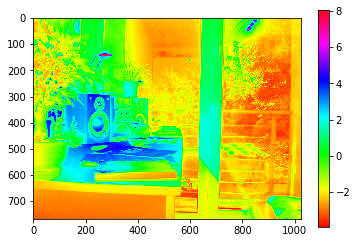

In [627]:
plt.imshow(r_r, cmap='hsv', interpolation='nearest')
plt.colorbar()
plt.show()

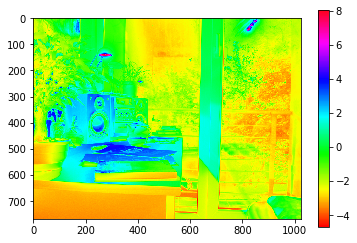

In [626]:
plt.imshow(g_r, cmap='hsv', interpolation='nearest')
plt.colorbar()
plt.show()

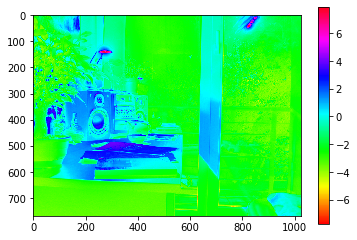

In [625]:
plt.imshow(b_r, cmap='hsv', interpolation='nearest')
plt.colorbar()
plt.show()